In [1]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid

from train_utils import *
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
from copy import deepcopy

import uproot
from root_pandas import read_root


import socket
my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
print('You are running on ', my_hostname)

Welcome to JupyROOT 6.22/02
You are running on  wudangshan


In [2]:
# Load the data

def load_data(debug=False):
    idir = '{}'.format('/nfs/user/pvischia/tth/dnn/' if 'cism.ucl.be' in my_hostname else './')
    file_tth = "{}/tree_2lss1tau.root".format(idir)
    key = "Friends"
    data_tth_orig = read_root(file_tth, key)
    if debug:
        data_tth_orig.describe()
    return data_tth_orig

In [3]:
# De-jag the data with respect to the jets

def dejag_data(data, debug=False):
    test=data['SelJet_pt']
    l = [len(i) for i in test]
    maxl = max(l)

    for lab in ['pt', 'eta', 'phi', 'mass', 'isBtag', 'isFromHadTop', 'btagDeepFlavB']:
        label='SelJet_%s'%lab
        tempLab=data[label]
        data.drop([label], axis=1, inplace=True)
        out = pd.DataFrame(tempLab.tolist(),columns=[ 'SelJet%s_%s'%(i, lab) for i in range(maxl)])
        data = pd.concat([data, out], axis=1)
    return data


In [4]:
# Remove ill-defined mass columns
def remove_masses(data, debug=False):
    for lab in data.columns:
        if 'mass' in lab:
            data.drop([lab], axis=1, inplace=True)
    return data

In [5]:
def load_feature_names(useJets=0, debug=False):
    thevars=[
            'Lep1_pt', 
            'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
             'nSelJets',
             'met', 'met_phi', 
             'HTT_score', 
             'Hj_tagger_hadTop',
             'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet',
             'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss',
             'dEtaBB_LLframe_2lss',
             'dEtaBB_2lss',
             'mTTH_2lss1tau',
             'theta_higgs_ttbar_TTHsystem_2lss1tau',
             'thetaTopTop_ttbarframe_2lss1tau', 
             'Tau_pt', 'Tau_eta', 'Tau_phi'
            ]
    if useJets>0:
        for i in range(useJets):
            thevars.append('SelJet%s_pt'%i)
            thevars.append('SelJet%s_eta'%i)
            thevars.append('SelJet%s_phi'%i)
            #thevars.append('SelJet%s_mass'%i)
            thevars.append('SelJet%s_isBtag'%i)
            thevars.append('SelJet%s_isFromHadTop'%i)
            thevars.append('SelJet%s_btagDeepFlavB'%i)
    if debug:
        print('Training features:', thevars)
        
    return thevars


In [6]:
def get_train_and_test(data, features, oddevensplit=False, fillna=False, debug=False):
    labs=deepcopy(features)
    if oddevensplit:
        labs.append('event')
    bkg = data[labs]
    sig = data[labs]

    if fillna:
        bkg.fillna(0, inplace=True)
        sig.fillna(0, inplace=True)


    wgtbkg=pd.DataFrame(data['weight_SM'].tolist(), columns=['weight'])
    wgtsig=pd.DataFrame(data['weight_CP_odd'].tolist(), columns=['weight'])

    labbkg = pd.DataFrame(np.zeros_like(bkg[features[0]]).tolist(), columns=['label'])
    labsig = pd.DataFrame(np.ones_like(bkg[features[0]]).tolist(), columns=['label'])

    bkg = pd.concat([bkg, wgtbkg, labbkg], axis=1)
    sig = pd.concat([sig, wgtsig, labsig], axis=1)

    sig['weight'] = sig['weight'].apply(lambda x: x if x <10. else 10.)

    labelled_set=pd.concat([sig, bkg], axis=0)
    if False:
        sns.pairplot(labelled_set, hue='label')
    if oddevensplit:
        labs.append('weight')
        X=labelled_set[labs]
        y=labelled_set['label']
        weight=labelled_set['weight']
        if debug:
            pd.set_option('display.max_columns', None)
            print(bkg.head())
            print(sig.head())

        X_wgt=X['weight']

        X_train=X[X['event']%2 == 0]
        X_test =X[X['event']%2 != 0]
        y_train=y[X['event']%2 == 0]
        y_test =y[X['event']%2 != 0]
        
        X_train_wgt=X_train['weight']
        X_train=X_train.drop(['weight'], axis=1, inplace=False)
        X_train=X_train.drop(['event'], axis=1, inplace=False)

        X_test_wgt=X_test['weight']
        X_test=X_test.drop(['weight'], axis=1, inplace=False)
        X_test=X_test.drop(['event'], axis=1, inplace=False)

        return {'X_train'     : X_train,
                'X_test'      : X_test, 
                'X_train_wgt' : X_train_wgt,
                'X_test_wgt'  : X_test_wgt,
                'y_train'     : y_train,
                'y_test'      : y_test 
               }
    else:
        labelled_set=shuffle(labelled_set)
        labs.append('weight')
        X=labelled_set[labs]
        y=labelled_set['label']
        weight=labelled_set['weight']
        if debug:
            pd.set_option('display.max_columns', None)
            print(bkg.head())
            print(sig.head())

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1534534, shuffle=True)

        X_train_wgt=X_train['weight']
        X_train=X_train.drop(['weight'], axis=1, inplace=False)
        X_test_wgt=X_test['weight']
        X_test=X_test.drop(['weight'], axis=1, inplace=False)

        return {'X_train'     : X_train,
                'X_test'      : X_test, 
                'X_train_wgt' : X_train_wgt,
                'X_test_wgt'  : X_test_wgt,
                'y_train'     : y_train,
                'y_test'      : y_test
               }
        #train_dmatrix = xgb.DMatrix(data=X_train,label=y_train,weight=X_train_wgt)
        #test_dmatrix = xgb.DMatrix(data=X_test,label=y_test,weight=X_test_wgt)

    #perm = np.random.permutation(len(X_train))
    #X_train = X_train[perm]
    #y_train = y_train[perm]
    #X_train_wgt = X_train_wgt[perm]

    #perm = np.random.permutation(len(X_train))
    #X_test = X_test[perm]
    #y_test = y_test[perm]
    #X_test_wgt = X_test_wgt[perm]


In [7]:
def plot_features(X, y, wgt, features, label):
    fix, axs= plt.subplots(10,10, figsize=(40,40))
    axs = axs.ravel()

    for i,ax in enumerate(axs):
        if i >= len(features):
            continue
        var=features[i]
        if var=='weight':
            continue
        ax=axs[i]
        #ax.hist(X_train[var], label='%s'%var)
        ax.hist(X[var][y[:]==0 ], weights=wgt[y[:]==0 ], density=True, alpha=0.5, bins=20)
        ax.hist(X[var][y[:]==1 ], weights=wgt[y[:]==1 ], density=True, alpha=0.5, bins=20)
        #ax.set_yscale('log')
        ax.set_title('%s dataset'%label)
        ax.set_xlabel(var)
    plt.show()
    plt.hist(wgt[y[:]==0 ], alpha=0.5, bins=np.linspace(0,20,200))
    plt.yscale("log")
    plt.hist(wgt[y[:]==1 ], alpha=0.5, bins=np.linspace(0,20,200))
    plt.title('%s dataset')
    plt.show()

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)


In [8]:
# Load the data
debug=False
data_tth_orig = load_data(debug=debug)
data_tth=data_tth_orig # save the original
data_tth=dejag_data(data_tth, debug=debug)
data_tth=remove_masses(data_tth, debug=debug)
    
the_initial_vars=load_feature_names(useJets=0, debug=debug) # add "useJets" quadrimomenta of jets


In [27]:
# Train a single model (the basic template)

def train_single_model(params, data, features, oddevensplit=True, fillna=False, debug=False):
    # Start with a first thing with all variables
    datasets= get_train_and_test(data, features, oddevensplit=oddevensplit, fillna=fillna, debug=debug)
    X_train     = datasets['X_train']
    X_test      = datasets['X_test']
    X_train_wgt = datasets['X_train_wgt']
    X_test_wgt  = datasets['X_test_wgt']
    y_train     = datasets['y_train']
    y_test      = datasets['y_test']

    if debug:
        plot_features(X_train, y_train, X_train_wgt, the_initial_vars, 'training')
        plot_features(X_test , y_test , X_test_wgt , the_initial_vars, 'test')
    # WORKING PROTOTYPE: xg_class = xgb.XGBClassifier(n_estimators=120, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=1)
    # Theoretically it should just accept "params=params"
    xg_class = xgb.XGBClassifier(n_estimators=params['n_estimators'], 
                                 max_depth=params['max_depth'],
                                 learning_rate=params['learning_rate'],
                                 subsample=params['subsample'],
                                 colsample_bytree=params['colsample_bytree'],
                                 gamma=params['gamma'],
                                 silent=True
                                )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xg_class.fit(X=X_train,y=y_train,eval_metric=["error", "logloss"], verbose=False, early_stopping_rounds=10, eval_set=eval_set,sample_weight=X_train_wgt,sample_weight_eval_set=[X_train_wgt, X_test_wgt])

    preds_train = xg_class.predict_proba(X_train)[:,0]
    preds_test = xg_class.predict_proba(X_test)[:,0]

    #preds_train=np.argmax(xg_class.predict_proba(X_train), axis=1)
    #preds_test =np.argmax(xg_class.predict_proba(X_test), axis=1)

    preds_cat_train = xg_class.predict(X_train)
    preds_cat_test  = xg_class.predict(X_test)
    # ROC curves
    auc_train=plot_roc(y_train, preds_train, sample_weight=X_train_wgt, label='training', plot=debug, debug=debug)
    auc_test=plot_roc(y_test, preds_test, sample_weight=X_test_wgt, label='test', plot=debug, debug=debug)

    accuracy_train = accuracy_score(y_train, preds_cat_train,sample_weight=X_train_wgt)
    print("Accuracy (train): %.2f%%" % (accuracy_train * 100.0))
    accuracy_test = accuracy_score(y_test, preds_cat_test, sample_weight=X_test_wgt)
    print("Accuracy (test): %.2f%%" % (accuracy_test * 100.0))

    if debug:
        plot_scores(y_train, preds_train, y_test, preds_test, X_train_wgt, X_test_wgt)

        xgb.plot_importance(xg_class)
        plt.figure(figsize = (16, 12))
        plt.show()        
        results = xg_class.evals_result()
        epochs = len(results['validation_0']['logloss'])
        x_axis = range(0, epochs)
        # plot log loss
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
        ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
        ax.legend()
        plt.ylabel('Log Loss')
        plt.title('XGBoost Log Loss')
        plt.show()
        # plot classification error
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['error'], label='Train')
        ax.plot(x_axis, results['validation_1']['error'], label='Test')
        ax.legend()
        plt.ylabel('Classification Error')
        plt.title('XGBoost Classification Error')
        plt.show()

        cm = confusion_matrix(y_test, preds_cat_test, sample_weight=X_test_wgt)
        plot_confusion_matrix(cm, ['CP odd', 'CP even'])
        plot_rel_pred(y_test, preds_test, 'test')
        plot_pred(y_test, preds_test, 'test')
        plot_weights(X_test_wgt, y_test, 'test')

    return {'auc_train': auc_train, 'auc_test': auc_test, 'model': xg_class, 'features': features, 'sorted_importance': dict(sorted(xg_class.get_booster().get_score(importance_type='weight').items(), key=lambda item: item[1])) }

In [11]:
# UNUSED (it claims XGBClassifier doesn't implement the fit() method, which is manifestly untrue)
def run_optimization_randomizedsearch(data, features, oddevensplit=True, fillna=False, debug=False):
    # Here must pass the parameters dictionary params, etc
    # (must change train_single_model to accept the dictionary of parameters,
    # and then set up the full grid scan)
    #train_res= train_single_model(data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)

    datasets= get_train_and_test(data, features, oddevensplit=oddevensplit, fillna=fillna, debug=debug)
    X_train     = datasets['X_train']
    X_test      = datasets['X_test']
    X_train_wgt = datasets['X_train_wgt']
    X_test_wgt  = datasets['X_test_wgt']
    y_train     = datasets['y_train']
    y_test      = datasets['y_test']

    grid={'learning_rate' : [0.01, 0.05, 0.1],
          'n_estimators' : [50, 100, 1000],
          'max_depth' : [3, 4, 8],
          'subsample' : [0.3, 0.8, 1.0],
          'colsample_bytree' : [0.3, 0.8, 1.0],
          'gamma' : [0, 1, 5]
         }
    list(ParameterGrid(grid))   
    xg_class = xgb.XGBClassifier(n_estimators=params['n_estimators'], 
                                 max_depth=params['max_depth'],
                                 learning_rate=params['learning_rate'],
                                 subsample=params['subsample'],
                                 colsample_bytree=params['colsample_bytree'],
                                 gamma=params['gamma'])
    
    folds = 3
    param_comb = 5

    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )
    eval_set = [(X_train, y_train), (X_test, y_test)]
    random_search.fit(X=X_train,y=y_train,eval_metric=["error", "logloss"], early_stopping_rounds=10, eval_set=eval_set,sample_weight=X_train_wgt,sample_weight_eval_set=[X_train_wgt, X_test_wgt])
    print('\n Best estimator:')
    print(random_search.best_estimator_)
    print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
    print(random_search.best_score_ * 2 - 1)
    print('\n Best hyperparameters:')
    print(random_search.best_params_)
    return random_search.best_estimator_

In [32]:
# Run the full hyperparameters optimization for a single set of variables

# I know I should use e.g. Parzen tree estimators from hyperopt as I did for the charged Higgs with 2016 dataset,
# but I feel lazy and the hyperparameter space I want to check is actually not that large,
# so I am implementing a simple grid search

def run_optimization(data, features, oddevensplit=True, fillna=False, debug=False):
    # Here must pass the parameters dictionary params, etc
    # (must change train_single_model to accept the dictionary of parameters,
    # and then set up the full grid scan)
    #train_res= train_single_model(data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)

    mode='emememme'
    
    if mode=='grid':
        grid={'learning_rate' : [0.01, 0.05, 0.1],
              'n_estimators' : [50, 100, 1000],
              'max_depth' : [3, 4, 8],
              'subsample' : [0.3, 0.8, 1.0],
              'colsample_bytree' : [0.3, 0.8, 1.0],
              'gamma' : [0, 1, 5]
             }
       
        listgrid=list(ParameterGrid(grid))   
        gridresults=[]
        for params in listgrid:
            train_res= train_single_model(params, data_tth, features, oddevensplit=True, fillna=False, debug=False)
            gridresults.append([train_res, train_res['auc_test']])
            print('MAXIMUM HAS NOW AUC', max(gridresults,key=lambda item:item[1])[1])
            print('FULL LIST IS', gridresults)
        return(max(gridresults,key=lambda item:item[1])[0])
    
    else:
        # Optimize separately (not optimal but runs in less time)
        
        base_params={'learning_rate' : 0.1,
          'n_estimators' : 120,
          'max_depth' : 4,
          'subsample' : 0.8,
          'colsample_bytree' : 1,
          'gamma' : 1
         }       
        
        # Optimize learning rate
        gridresults=[]
        for lr in [0.01, 0.05, 0.1]:
            params=deepcopy(base_params)
            params['learning_rate'] = lr
            train_res= train_single_model(params, data_tth, features, oddevensplit=True, fillna=False, debug=False)
            gridresults.append([lr, deepcopy(train_res['auc_test'])])
            print('MAXIMUM HAS NOW AUC', max(gridresults,key=lambda item:item[1])[1])
            print('FULL LIST IS', gridresults)
        base_params['learning_rate'] = max(gridresults,key=lambda item:item[1])[0]

        # Optimize n_estimators
        gridresults=[]
        for nest in [50, 100, 120, 1000]:
            params=deepcopy(base_params)
            params['n_estimators'] = nest
            train_res= train_single_model(params, data_tth, features, oddevensplit=True, fillna=False, debug=False)
            gridresults.append([nest, deepcopy(train_res['auc_test'])])
            print('MAXIMUM HAS NOW AUC', max(gridresults,key=lambda item:item[1])[1])
            print('FULL LIST IS', gridresults)
        base_params['n_estimators'] = max(gridresults,key=lambda item:item[1])[0]
        
        # Optimize max_depth
        gridresults=[]
        for md in [3, 4, 8]:
            params=deepcopy(base_params)
            params['max_depth'] = md
            train_res= train_single_model(params, data_tth, features, oddevensplit=True, fillna=False, debug=False)
            gridresults.append([md, deepcopy(train_res['auc_test'])])
            print('MAXIMUM HAS NOW AUC', max(gridresults,key=lambda item:item[1])[1])
            print('FULL LIST IS', gridresults)
        base_params['max_depth'] = max(gridresults,key=lambda item:item[1])[0]
            
        # Optimize subsample
        gridresults=[]
        for ss in [0.3, 0.8, 1.0]:
            params=deepcopy(base_params)
            params['subsample'] = ss
            train_res= train_single_model(params, data_tth, features, oddevensplit=True, fillna=False, debug=False)
            gridresults.append([ss, deepcopy(train_res['auc_test'])])
            print('MAXIMUM HAS NOW AUC', max(gridresults,key=lambda item:item[1])[1])
            print('FULL LIST IS', gridresults)
        base_params['subsample'] = max(gridresults,key=lambda item:item[1])[0]
   
        # Optimize colsample_bytree
        gridresults=[]
        for cs in [0.3, 0.8, 1.0]:
            params=deepcopy(base_params)
            params['colsample_bytree'] = cs
            train_res= train_single_model(params, data_tth, features, oddevensplit=True, fillna=False, debug=False)
            gridresults.append([cs, deepcopy(train_res['auc_test'])])
            print('MAXIMUM HAS NOW AUC', max(gridresults,key=lambda item:item[1])[1])
            print('FULL LIST IS', gridresults)
        base_params['colsample_bytree'] = max(gridresults,key=lambda item:item[1])[0]
   
        # Optimize gamma
        gridresults=[]
        best=None
        for gm in [0, 1, 5]:
            params=deepcopy(base_params)
            params['gamma'] = gm
            train_res= train_single_model(params, data_tth, features, oddevensplit=True, fillna=False, debug=False)
            gridresults.append([gm, deepcopy(train_res['auc_test'])])
            print('MAXIMUM HAS NOW AUC', max(gridresults,key=lambda item:item[1])[1])
            print('FULL LIST IS', gridresults)
        base_params['gamma'] = max(gridresults,key=lambda item:item[1])[0]
        # Now do a final training with the best parset 
        train_res= train_single_model(base_params, data_tth, features, oddevensplit=True, fillna=False, debug=False)
        return train_res

In [33]:
# Run on a single model
if False:
    params={'learning_rate' : 0.1,
          'n_estimators' : 120,
          'max_depth' : 4,
          'subsample' : 0.8,
          'colsample_bytree' : 1,
          'gamma' : 1
         }
    train_res= train_single_model(params, data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)




In [34]:
# %%capture  # this is necessary if running run_optimization in grid mode
# Full  optimization, where "best" is w.r.t. the AUC metric:
# 1. start with a variable set
# 2. find the model with the best hyperparameter values for that set of variables
# 3. remove the variable that is the least important in this model
# 4. return to point 2
# This ends when removing variables doesnt' improve the AUC anymore


# So far for each variables set I run a single model.
# When I'll have implemented run_optimization (for a given features set) I'll substitute a call to it here
# in place of the call to train_single_model
auc_per_var=[]
features_set=deepcopy(the_initial_vars)
for i in range(len(the_initial_vars)):
    train_res=run_optimization(data_tth, features_set, oddevensplit=True, fillna=False, debug=False)
    auc_per_var.append([deepcopy(train_res['auc_test']), deepcopy(features_set), deepcopy(train_res)])
    print('Trained on', features_set) 
    print('or ', train_res['features'])
    print('Importance', train_res['sorted_importance'])
    print('Features set', features_set)
    print('removing ', min(train_res['sorted_importance'].items(), key=lambda x: x[1])[0])
    features_set.remove(min(train_res['sorted_importance'].items(), key=lambda x: x[1])[0])
    print('Next time on', features_set)  

   

[15:02:25] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.56%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.6306620386002973
FULL LIST IS [[0.01, 0.6306620386002973]]
[15:02:28] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.98%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6398964734944669
FULL LIST IS [[0.01, 0.6306620386002973], [0.05, 0.6398964734944669]]
[15:02:31] WARNING: ../src/learner.cc:516: 
Parameters: { si

[15:03:18] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.98%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6398964734944669
FULL LIST IS [[0, 0.6396209731122143], [1, 0.6398964734944669]]
[15:03:23] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.91%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6400863086959102
FULL LIST IS [[0, 0.6396209731122143], [1, 0.6398964734944669], [5, 0.6400863086959102]]
[15:03:26] WARNING:

Accuracy (train): 84.80%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6391637760083058
FULL LIST IS [[3, 0.6368573254073732], [4, 0.6391637760083058], [8, 0.6357913734568189]]
[15:04:05] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.81%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6357745230415399
FULL LIST IS [[0.3, 0.6357745230415399]]
[15:04:07] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.90%
Accuracy (test): 

Accuracy (train): 82.85%
Accuracy (test): 82.31%
MAXIMUM HAS NOW AUC 0.63930033314562
FULL LIST IS [[0.01, 0.6305385415825022], [0.05, 0.63930033314562], [0.1, 0.6379253825918973]]
[15:04:43] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.57%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.6347119131090511
FULL LIST IS [[50, 0.6347119131090511]]
[15:04:44] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.84%
Accuracy (test

Accuracy (train): 82.95%
Accuracy (test): 82.28%
Trained on ['Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'nSelJets', 'met', 'HTT_score', 'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'theta_higgs_ttbar_TTHsystem_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta', 'Tau_phi']
or  ['Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'nSelJets', 'met', 'HTT_score', 'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'theta_higgs_ttbar_TTHsystem_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta', 'Tau_phi']
Importance {'theta_higgs_ttbar_TTHsystem_2lss1tau': 20, 'nSelJets': 21, 'Tau_phi': 41, 'HTT_score': 42, 'dPhiBB_LLframe_2lss': 53, 'Hj_tagger_hadTop':

Accuracy (train): 82.74%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6385026045181689
FULL LIST IS [[0.3, 0.6369194084234161], [0.8, 0.6385026045181689], [1.0, 0.6354160916007093]]
[15:06:17] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.72%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.6376410624775255
FULL LIST IS [[0.3, 0.6376410624775255]]
[15:06:19] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.91%
Accuracy (t

Accuracy (train): 82.85%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6382809466851548
FULL LIST IS [[50, 0.6349857293241807], [100, 0.6382809466851548], [120, 0.6382809466851548], [1000, 0.6382809466851548]]
[15:06:56] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.57%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6364941191434821
FULL LIST IS [[3, 0.6364941191434821]]
[15:06:59] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (t

Accuracy (train): 82.52%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.6303002864622331
FULL LIST IS [[0.01, 0.6303002864622331]]
[15:07:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 83.00%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6384027552760281
FULL LIST IS [[0.01, 0.6303002864622331], [0.05, 0.6384027552760281]]
[15:07:41] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.87%
Accuracy (test): 82.33%
MAXIMUM HAS

Accuracy (train): 83.03%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6384192664020686
FULL LIST IS [[0, 0.6384017830665247], [1, 0.6384192664020686]]
[15:08:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 83.05%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6386991129677384
FULL LIST IS [[0, 0.6384017830665247], [1, 0.6384192664020686], [5, 0.6386991129677384]]
[15:08:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 8

Accuracy (train): 82.71%
Accuracy (test): 82.32%
MAXIMUM HAS NOW AUC 0.6372277498568968
FULL LIST IS [[0.3, 0.6298537905180661], [0.8, 0.6372277498568968]]
[15:09:05] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.84%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6372277498568968
FULL LIST IS [[0.3, 0.6298537905180661], [0.8, 0.6372277498568968], [1.0, 0.6345958975793163]]
[15:09:06] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy 

Accuracy (train): 82.97%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6371565528805966
FULL LIST IS [[50, 0.6341591265010817], [100, 0.6365907003621822], [120, 0.6371565528805966]]
[15:09:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.97%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6371565528805966
FULL LIST IS [[50, 0.6341591265010817], [100, 0.6365907003621822], [120, 0.6371565528805966], [1000, 0.6371565528805966]]
[15:09:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Plea

Accuracy (train): 82.52%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.6303001269655828
FULL LIST IS [[0.01, 0.6303001269655828]]
[15:10:17] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.95%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6372340364295029
FULL LIST IS [[0.01, 0.6303001269655828], [0.05, 0.6372340364295029]]
[15:10:20] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.81%
Accuracy (test): 82.27%
MAXIMUM HAS

Accuracy (train): 82.95%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6377458058342171
FULL LIST IS [[0, 0.6368413653672874], [1, 0.6377458058342171]]
[15:11:06] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.90%
Accuracy (test): 82.26%
MAXIMUM HAS NOW AUC 0.6377458058342171
FULL LIST IS [[0, 0.6368413653672874], [1, 0.6377458058342171], [5, 0.6372405444251867]]
[15:11:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 8

Accuracy (train): 82.89%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6373527258010302
FULL LIST IS [[0.3, 0.6354483775497209], [0.8, 0.6373527258010302]]
[15:11:43] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.87%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6373527258010302
FULL LIST IS [[0.3, 0.6354483775497209], [0.8, 0.6373527258010302], [1.0, 0.6355981751856399]]
[15:11:45] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy 

Accuracy (train): 82.98%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6383163369833886
FULL LIST IS [[50, 0.6369914301682559], [100, 0.6383163369833886], [120, 0.6383163369833886], [1000, 0.6383163369833886]]
[15:12:16] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.67%
Accuracy (test): 82.25%
MAXIMUM HAS NOW AUC 0.6371048733094377
FULL LIST IS [[3, 0.6371048733094377]]
[15:12:17] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (t

Accuracy (train): 82.89%
Accuracy (test): 82.26%
MAXIMUM HAS NOW AUC 0.6362417555104687
FULL LIST IS [[0.01, 0.6296244880034304], [0.05, 0.6362417555104687]]
[15:12:43] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 83.00%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6365591594732682
FULL LIST IS [[0.01, 0.6296244880034304], [0.05, 0.6362417555104687], [0.1, 0.6365591594732682]]
[15:12:45] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accur

Accuracy (train): 82.79%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6380107488785168
FULL LIST IS [[0, 0.6375148687040791], [1, 0.6379993132809916], [5, 0.6380107488785168]]
[15:13:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.79%
Accuracy (test): 82.28%
Trained on ['Lep2_pt', 'Lep2_eta', 'Lep2_phi', 'met', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta']
or  ['Lep2_pt', 'Lep2_eta', 'Lep2_phi', 'met', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 

Accuracy (train): 82.50%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.6364351346309154
FULL LIST IS [[0.3, 0.6364351346309154]]
[15:13:43] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.55%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6364507497748948
FULL LIST IS [[0.3, 0.6364351346309154], [0.8, 0.6364507497748948]]
[15:13:45] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.56%
Accuracy (test): 82.28%
MAXIMUM HAS NO

Accuracy (train): 82.76%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6365384477085998
FULL LIST IS [[3, 0.6365384477085998], [4, 0.6362801521531058]]
[15:14:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 84.48%
Accuracy (test): 82.31%
MAXIMUM HAS NOW AUC 0.6365384477085998
FULL LIST IS [[3, 0.6365384477085998], [4, 0.6362801521531058], [8, 0.6320810945989399]]
[15:14:18] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 8

Accuracy (train): 82.51%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.633147916947994
FULL LIST IS [[50, 0.633147916947994]]
[15:14:42] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.77%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6356012065011547
FULL LIST IS [[50, 0.633147916947994], [100, 0.6356012065011547]]
[15:14:44] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.78%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC

Accuracy (train): 82.50%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.6299411308209981
FULL LIST IS [[0.01, 0.6299411308209981]]
[15:15:18] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.68%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6353987674998863
FULL LIST IS [[0.01, 0.6299411308209981], [0.05, 0.6353987674998863]]
[15:15:20] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.66%
Accuracy (test): 82.27%
MAXIMUM HAS

Accuracy (train): 82.52%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6375644013175981
FULL LIST IS [[0, 0.6375181344651706], [1, 0.6375644013175981]]
[15:15:53] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.52%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6375644013175981
FULL LIST IS [[0, 0.6375181344651706], [1, 0.6375644013175981], [5, 0.6371455881764392]]
[15:15:54] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 8

Accuracy (train): 82.50%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.631307574397915
FULL LIST IS [[0.3, 0.631307574397915]]
[15:16:22] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.50%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6342120211187026
FULL LIST IS [[0.3, 0.631307574397915], [0.8, 0.6342120211187026]]
[15:16:24] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.50%
Accuracy (test): 82.28%
MAXIMUM HAS NOW A

Accuracy (train): 84.23%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.633850254706005
FULL LIST IS [[3, 0.633850254706005], [4, 0.6337288048070875], [8, 0.6296104972674734]]
[15:16:49] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.54%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6327222480723291
FULL LIST IS [[0.3, 0.6327222480723291]]
[15:16:51] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.50%
Accuracy (test): 82

Accuracy (train): 82.70%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6319772968330046
FULL LIST IS [[50, 0.6307378488466558], [100, 0.6319772968330046], [120, 0.6319772968330046]]
[15:17:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.70%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6319772968330046
FULL LIST IS [[50, 0.6307378488466558], [100, 0.6319772968330046], [120, 0.6319772968330046], [1000, 0.6319772968330046]]
[15:17:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Plea

Accuracy (train): 82.62%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6283338821450364
FULL LIST IS [[0.01, 0.6267081137865076], [0.05, 0.6283338821450364]]
[15:17:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.58%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6283338821450364
FULL LIST IS [[0.01, 0.6267081137865076], [0.05, 0.6283338821450364], [0.1, 0.6270353359417584]]
[15:17:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accur

Accuracy (train): 82.50%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6295343128074574
FULL LIST IS [[0, 0.6295292468750775], [1, 0.6295343128074574], [5, 0.6295037196307981]]
[15:18:00] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.50%
Accuracy (test): 82.28%
Trained on ['mindr_lep2_jet', 'mindr_lep1_jet', 'dPhiLL_BBframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau']
or  ['mindr_lep2_jet', 'mindr_lep1_jet', 'dPhiLL_BBframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau']
Importance {'thetaTopTop_ttbarframe_2lss1tau': 80, 'dPhiLL_BBframe_2lss': 83, 'mindr_lep2_jet': 95, 'dEtaBB_2lss': 112, 'mindr_lep1_jet': 132, 'mTTH_2lss1tau': 181}
Features set [

Accuracy (train): 82.52%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6264263540562216
FULL LIST IS [[0.3, 0.62054506536023], [0.8, 0.6264263540562216]]
[15:18:23] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.53%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6264263540562216
FULL LIST IS [[0.3, 0.62054506536023], [0.8, 0.6264263540562216], [1.0, 0.6261674563799369]]
[15:18:24] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (tra

Accuracy (train): 82.50%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6265167492433803
FULL LIST IS [[0.3, 0.6265167492433803]]
[15:18:42] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.53%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6265167492433803
FULL LIST IS [[0.3, 0.6265167492433803], [0.8, 0.6260503709485092]]
[15:18:43] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.52%
Accuracy (test): 82.28%
MAXIMUM HAS NO

Accuracy (train): 82.53%
Accuracy (test): 82.27%
MAXIMUM HAS NOW AUC 0.6218174832305186
FULL LIST IS [[3, 0.6218174832305186]]
[15:18:59] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.56%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6218477146190998
FULL LIST IS [[3, 0.6218174832305186], [4, 0.6218477146190998]]
[15:19:01] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 83.56%
Accuracy (test): 82.26%
MAXIMUM HAS NOW AUC 

Accuracy (train): 82.56%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6001402368786177
FULL LIST IS [[50, 0.5997798780008337], [100, 0.6001402368786177]]
[15:19:22] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.56%
Accuracy (test): 82.28%
MAXIMUM HAS NOW AUC 0.6001402368786177
FULL LIST IS [[50, 0.5997798780008337], [100, 0.6001402368786177], [120, 0.6001402368786177]]
[15:19:23] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (t

Accuracy (train): 82.52%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.5883556161072223
FULL LIST IS [[0.01, 0.5883556161072223], [0.05, 0.5870301679585167]]
[15:19:43] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.52%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.5883556161072223
FULL LIST IS [[0.01, 0.5883556161072223], [0.05, 0.5870301679585167], [0.1, 0.5873133647315903]]
[15:19:44] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accur

Accuracy (train): 82.50%
Accuracy (test): 82.29%
MAXIMUM HAS NOW AUC 0.5888205576127941
FULL LIST IS [[0, 0.5888205576127941], [1, 0.5887651220557488], [5, 0.5870468408743295]]
[15:20:01] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 82.54%
Accuracy (test): 82.30%
Trained on ['mTTH_2lss1tau']
or  ['mTTH_2lss1tau']
Importance {'mTTH_2lss1tau': 651}
Features set ['mTTH_2lss1tau']
removing  mTTH_2lss1tau
Next time on []


{'auc_train': 0.6970971050379757, 'auc_test': 0.6400863086959102, 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None), 'features': ['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'nSelJets', 'met', 'met_phi', 'HTT_score', 'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau'

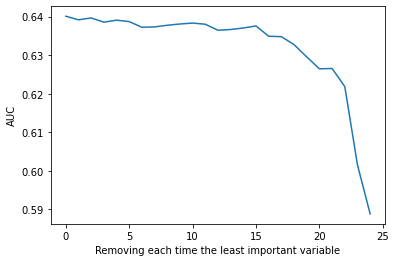

In [35]:
plt.plot([i for i in range(len(auc_per_var))], [i[0] for i in auc_per_var])
plt.xlabel('Removing each time the least important variable')
plt.ylabel('AUC')

# Access best model
best_model_set= max(auc_per_var,key=lambda item:item[0])[2]

print(best_model_set)

In [ ]:
# Save the best model

import pickle as pkl
pkl.dump(best_model_set['model'], open("XGB_model-2lss1tau.pkl", "wb"))                                                      


In [53]:
print(best_model_set['model'].get_booster().get_dump())
#from xgboost2tmva import *
from SaveAsTMVA_XML import convert_model
ivars=[]
print("CHICHICHICHICHI", best_model_set['features'])
for i in best_model_set['features']:  
    ivars.append(('f{}'.format(i), 'F')) 
convert_model(best_model_set['model'].get_booster().get_dump(),input_variables=ivars,output_xml='xgboost-2lss1tau.xml')

['0:[dEtaBB_2lss<2.00798035] yes=1,no=2,missing=1\n\t1:[mTTH_2lss1tau<615.691345] yes=3,no=4,missing=3\n\t\t3:[Lep2_eta<2.11474609] yes=7,no=8,missing=7\n\t\t\t7:[mindr_lep1_jet<1.81564569] yes=15,no=16,missing=15\n\t\t\t\t15:leaf=-0.0769151971\n\t\t\t\t16:leaf=-0.0688129142\n\t\t\t8:[Lep2_eta<2.11743164] yes=17,no=18,missing=17\n\t\t\t\t17:leaf=0.0571600981\n\t\t\t\t18:leaf=-0.0573659837\n\t\t4:[mindr_lep1_jet<1.92527652] yes=9,no=10,missing=9\n\t\t\t9:[dEtaBB_2lss<1.52653503] yes=19,no=20,missing=19\n\t\t\t\t19:leaf=-0.0666018501\n\t\t\t\t20:leaf=-0.0507126525\n\t\t\t10:[met<14.9164228] yes=21,no=22,missing=21\n\t\t\t\t21:leaf=0.0260662027\n\t\t\t\t22:leaf=-0.0454186313\n\t2:[mTTH_2lss1tau<509.238647] yes=5,no=6,missing=5\n\t\t5:[dPhiLL_BBframe_2lss<-3.09381461] yes=11,no=12,missing=11\n\t\t\t11:leaf=0.0256942809\n\t\t\t12:[Lep1_eta<-0.519958496] yes=25,no=26,missing=25\n\t\t\t\t25:leaf=-0.0774972737\n\t\t\t\t26:leaf=-0.0546327904\n\t\t6:[dEtaLL_BBframe_2lss<0.377306789] yes=13,no=14

KeyError: 'dEtaBB_2lss'

{'auc_train': 0.6970971050379757, 'auc_test': 0.6400863086959102, 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None), 'features': ['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'nSelJets', 'met', 'met_phi', 'HTT_score', 'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau'

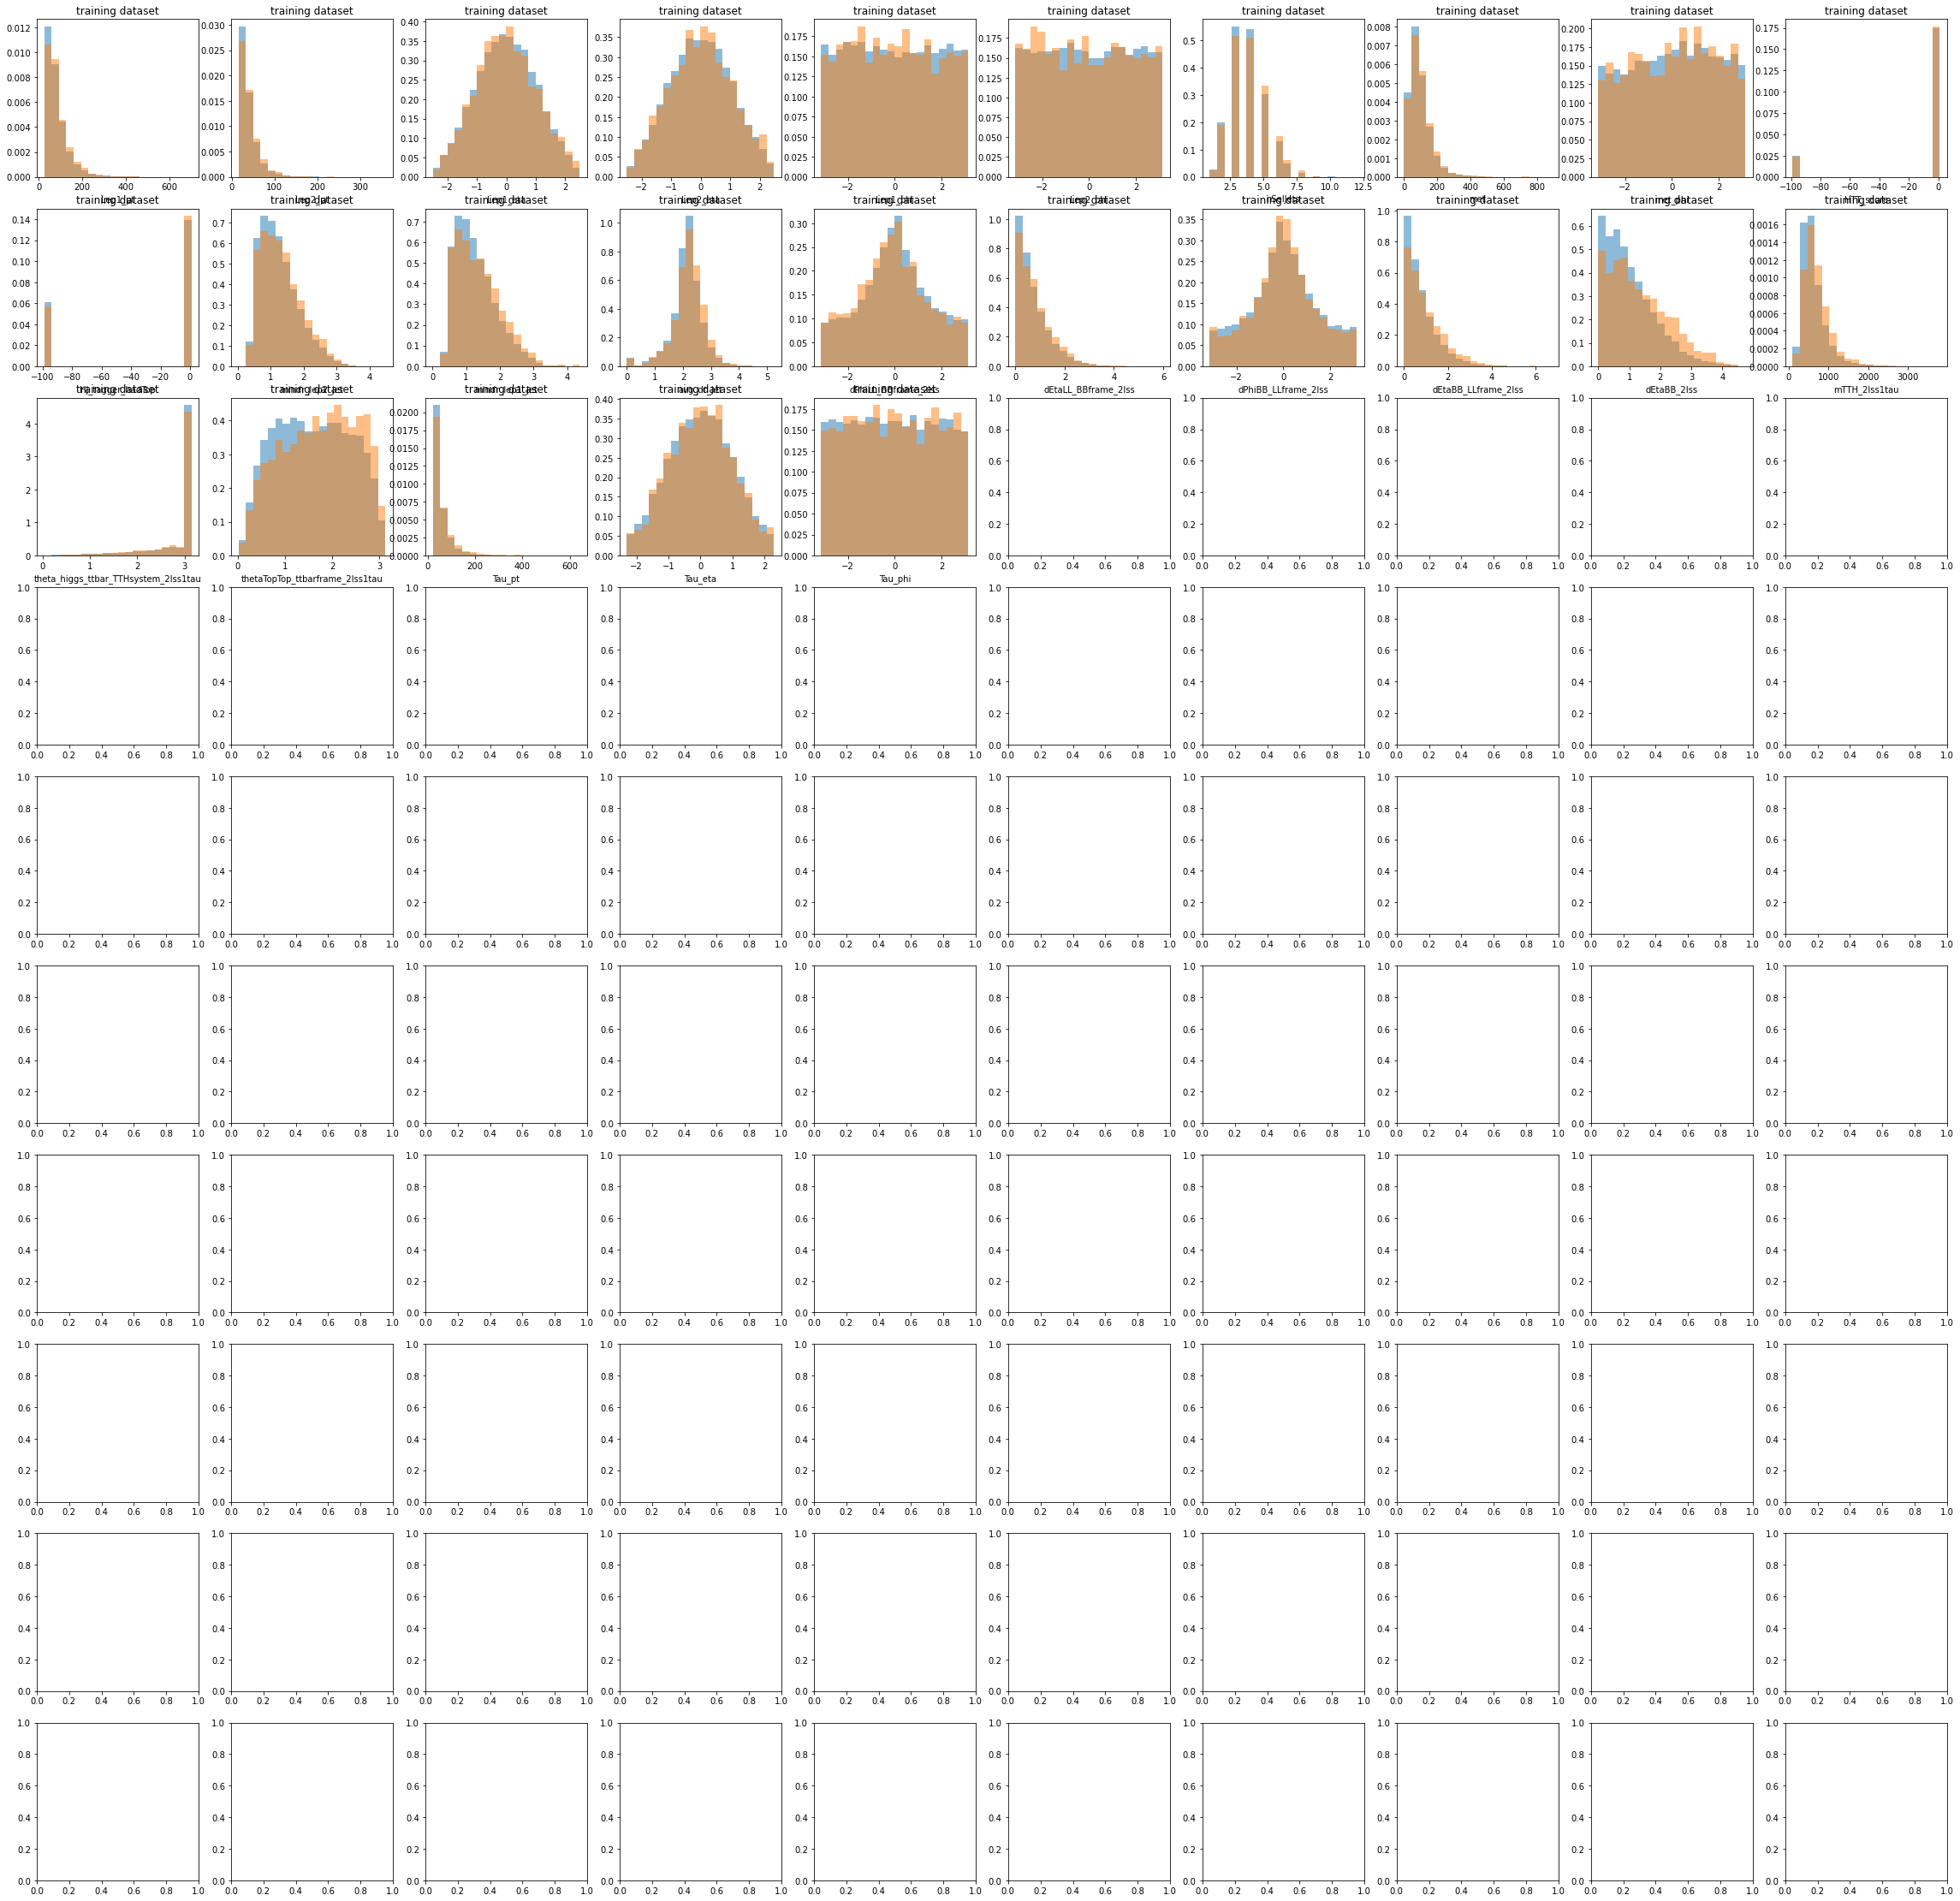

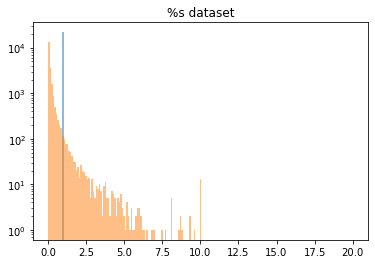

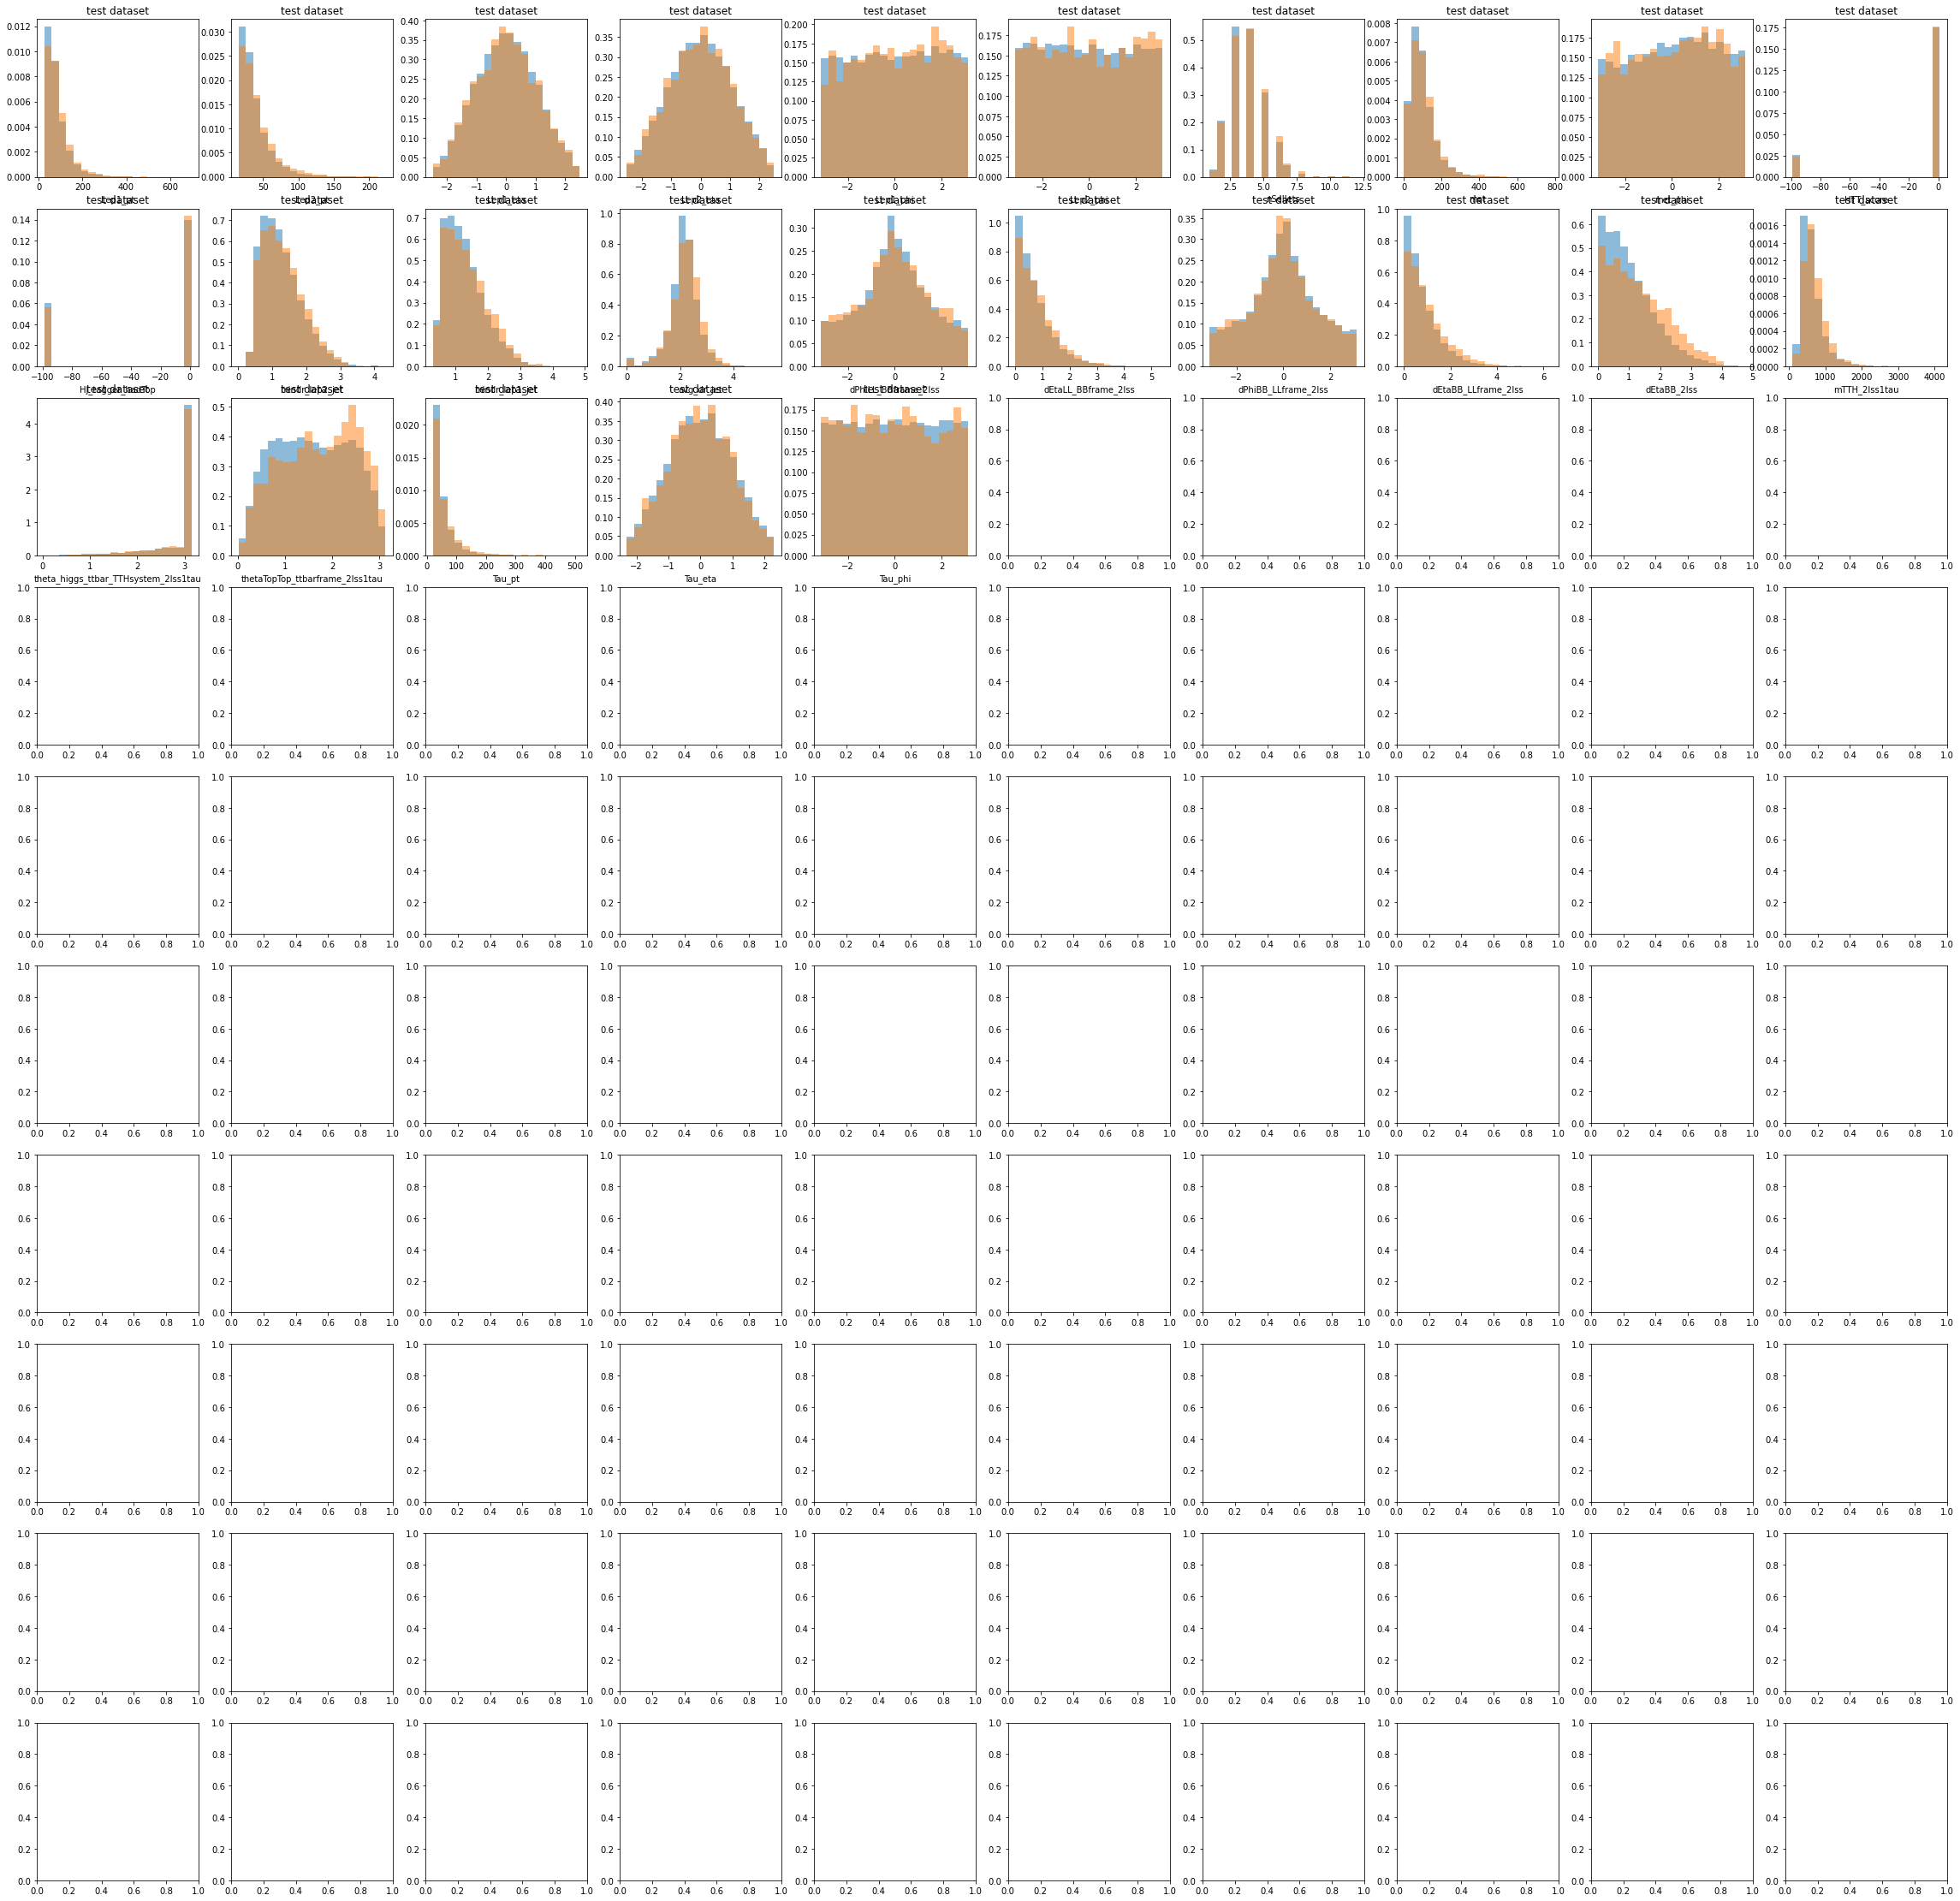

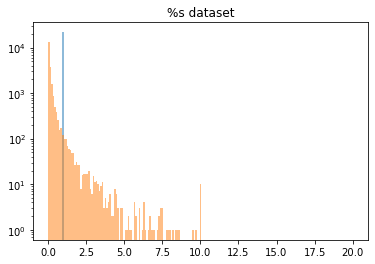

[16:13:23] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


FPR range: 0.0 1.0
TPR range: 0.0 1.0


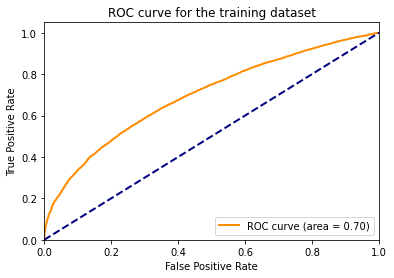

FPR range: 0.0 1.0
TPR range: 0.0 1.0


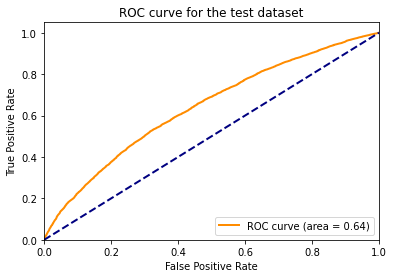

Accuracy (train): 82.91%
Accuracy (test): 82.27%


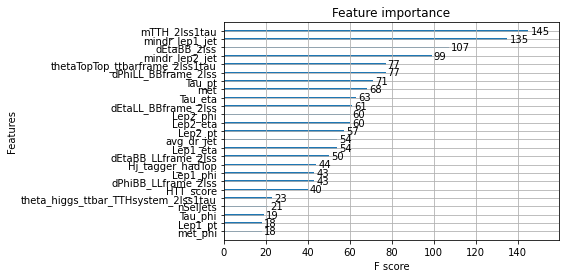

<Figure size 1152x864 with 0 Axes>

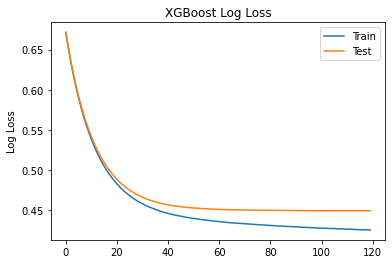

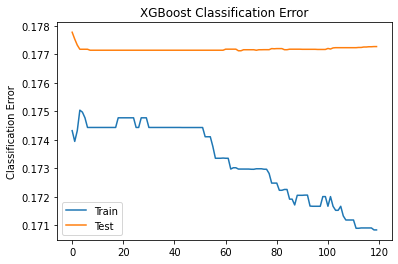

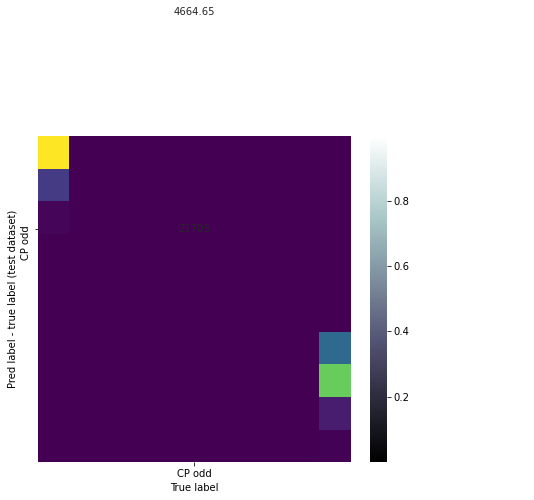

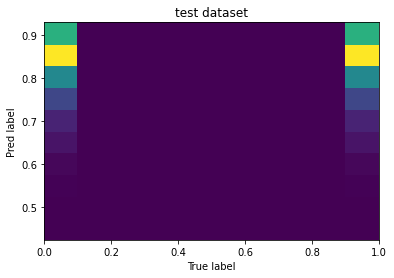

{'auc_train': 0.6970971050379757,
 'auc_test': 0.6400863086959102,
 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.05, max_delta_step=0, max_depth=4,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
               subsample=0.8, tree_method='exact', validate_parameters=1,
               verbosity=None),
 'features': ['Lep1_pt',
  'Lep2_pt',
  'Lep1_eta',
  'Lep2_eta',
  'Lep1_phi',
  'Lep2_phi',
  'nSelJets',
  'met',
  'met_phi',
  'HTT_score',
  'Hj_tagger_hadTop',
  'mindr_lep2_jet',
  'mindr_lep1_jet',
  'avg_dr_jet',
  'dPhiLL_BBframe_2lss',
  'dEtaLL_BBframe_2lss',
  'dPhiBB_LLframe_2lss',
  'dEtaBB_LL

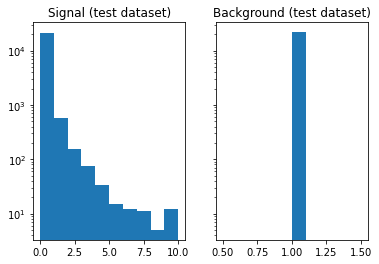

In [62]:
# Retrain best model to make plots
best_model = best_model_set['model']
print(best_model_set)
# Copied by hand from best_model_set, must find a way of doing it automatically
params={'learning_rate' : 0.05,
          'n_estimators' : 120,
          'max_depth' : 4,
          'subsample' : 0.8,
          'colsample_bytree' : 1,
          'gamma' : 5
         }
tsm= train_single_model(params, data_tth, best_model_set['features'], oddevensplit=True, fillna=False, debug=True)


In [63]:
print(auc_per_var[0])

[0.6400863086959102, ['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'nSelJets', 'met', 'met_phi', 'HTT_score', 'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'theta_higgs_ttbar_TTHsystem_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta', 'Tau_phi'], {'auc_train': 0.6970971050379757, 'auc_test': 0.6400863086959102, 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1

In [64]:
print(len(best_model_set['features']))
print(len(the_initial_vars))

25
25


In [11]:
# Load the best model

import pickle as pkl
best_model = pkl.load(open("XGB_model-2lss1tau.pkl", "rb"))


      Lep1_pt    Lep2_pt  Lep1_eta  Lep2_eta  Lep1_phi  Lep2_phi  nSelJets  \
0   65.060692  28.938643  1.078369  1.967041 -2.828613  0.322815         3   
1  116.764389  70.972816 -1.463379 -1.106201  0.728760  0.578613         5   
2   81.278633  18.616665  2.194824  1.765625  0.528198 -1.604736         3   
3  125.633125  60.191414  0.605103  0.173615 -1.022949 -3.012695         5   
4   51.864380  38.232483  1.734131  0.914551 -0.113174 -2.233887         5   

          met   met_phi  HTT_score  Hj_tagger_hadTop  mindr_lep2_jet  \
0  172.891312 -2.951660   0.024360        -99.000000        0.691453   
1   46.341152 -0.300293   0.976259          0.253784        1.549022   
2  167.847046 -1.923584   0.070585        -99.000000        0.990875   
3   87.626472  2.803223   0.895850          0.437349        0.741387   
4   69.026421 -2.179688   0.947869          0.721005        0.486511   

   mindr_lep1_jet  avg_dr_jet  dPhiLL_BBframe_2lss  dEtaLL_BBframe_2lss  \
0        1.177768    1.

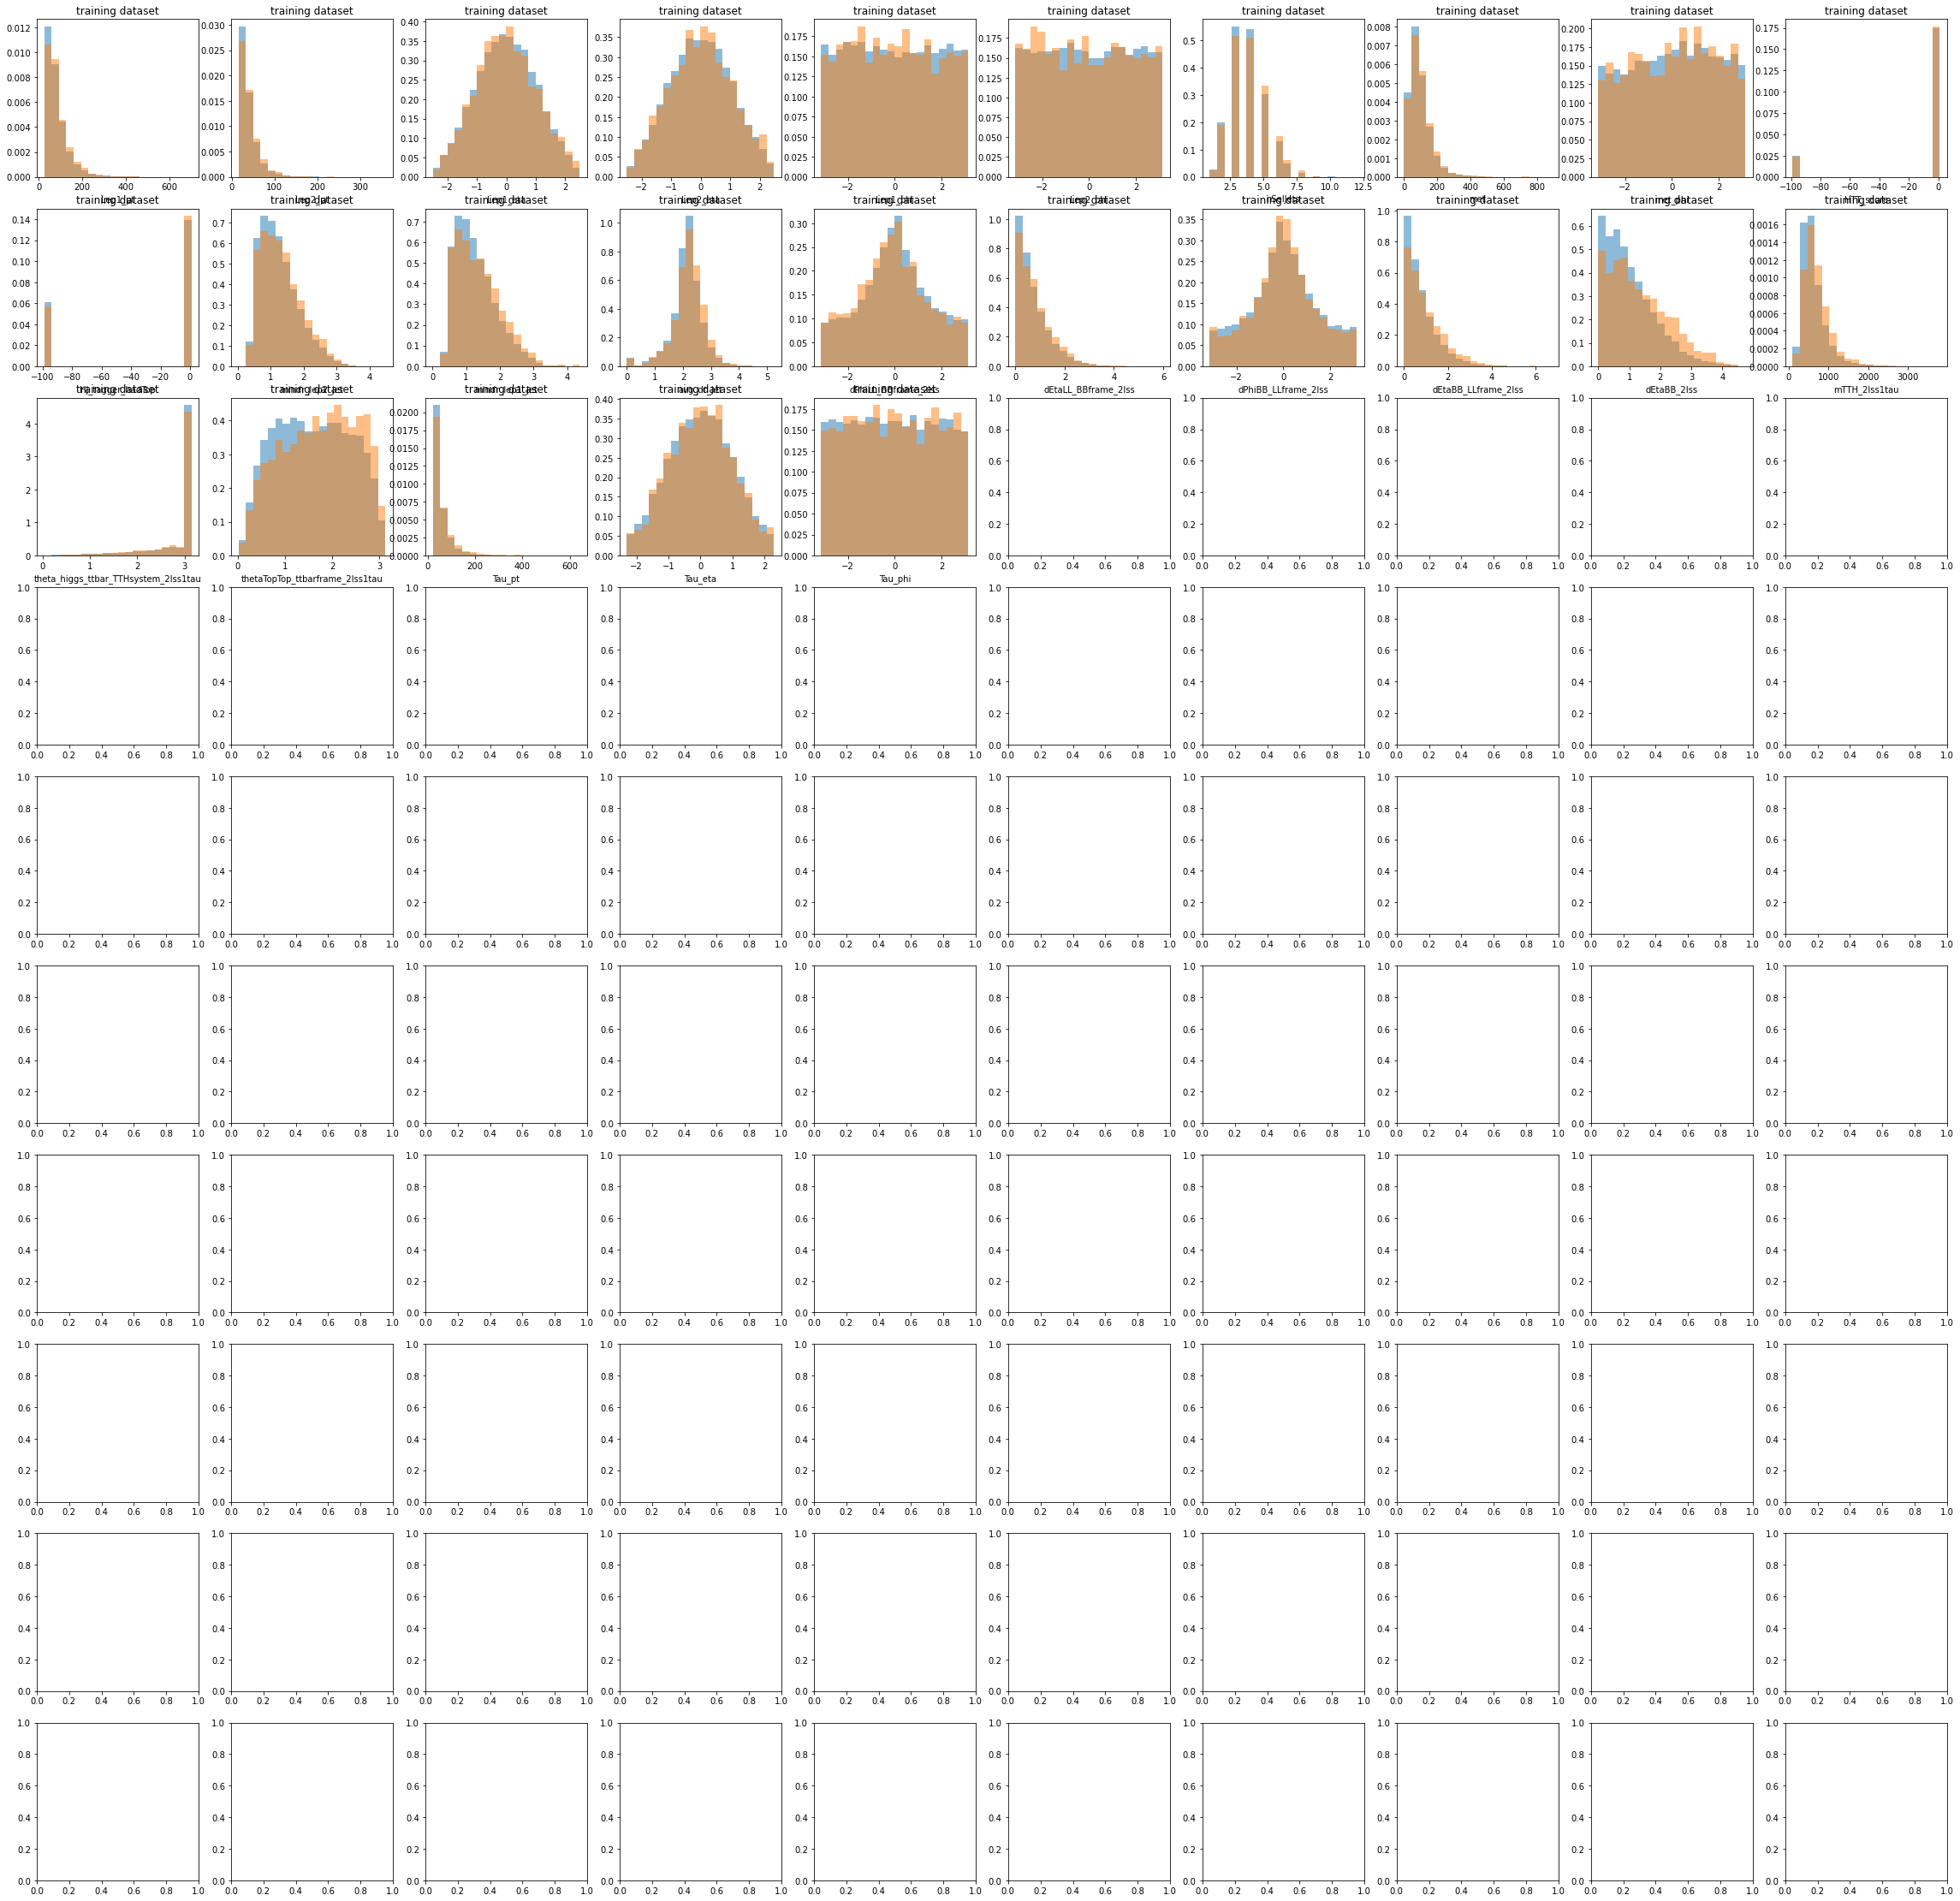

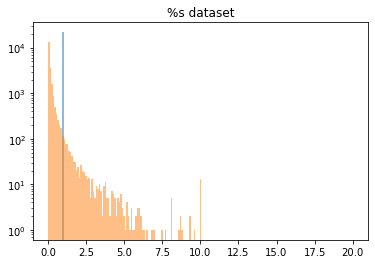

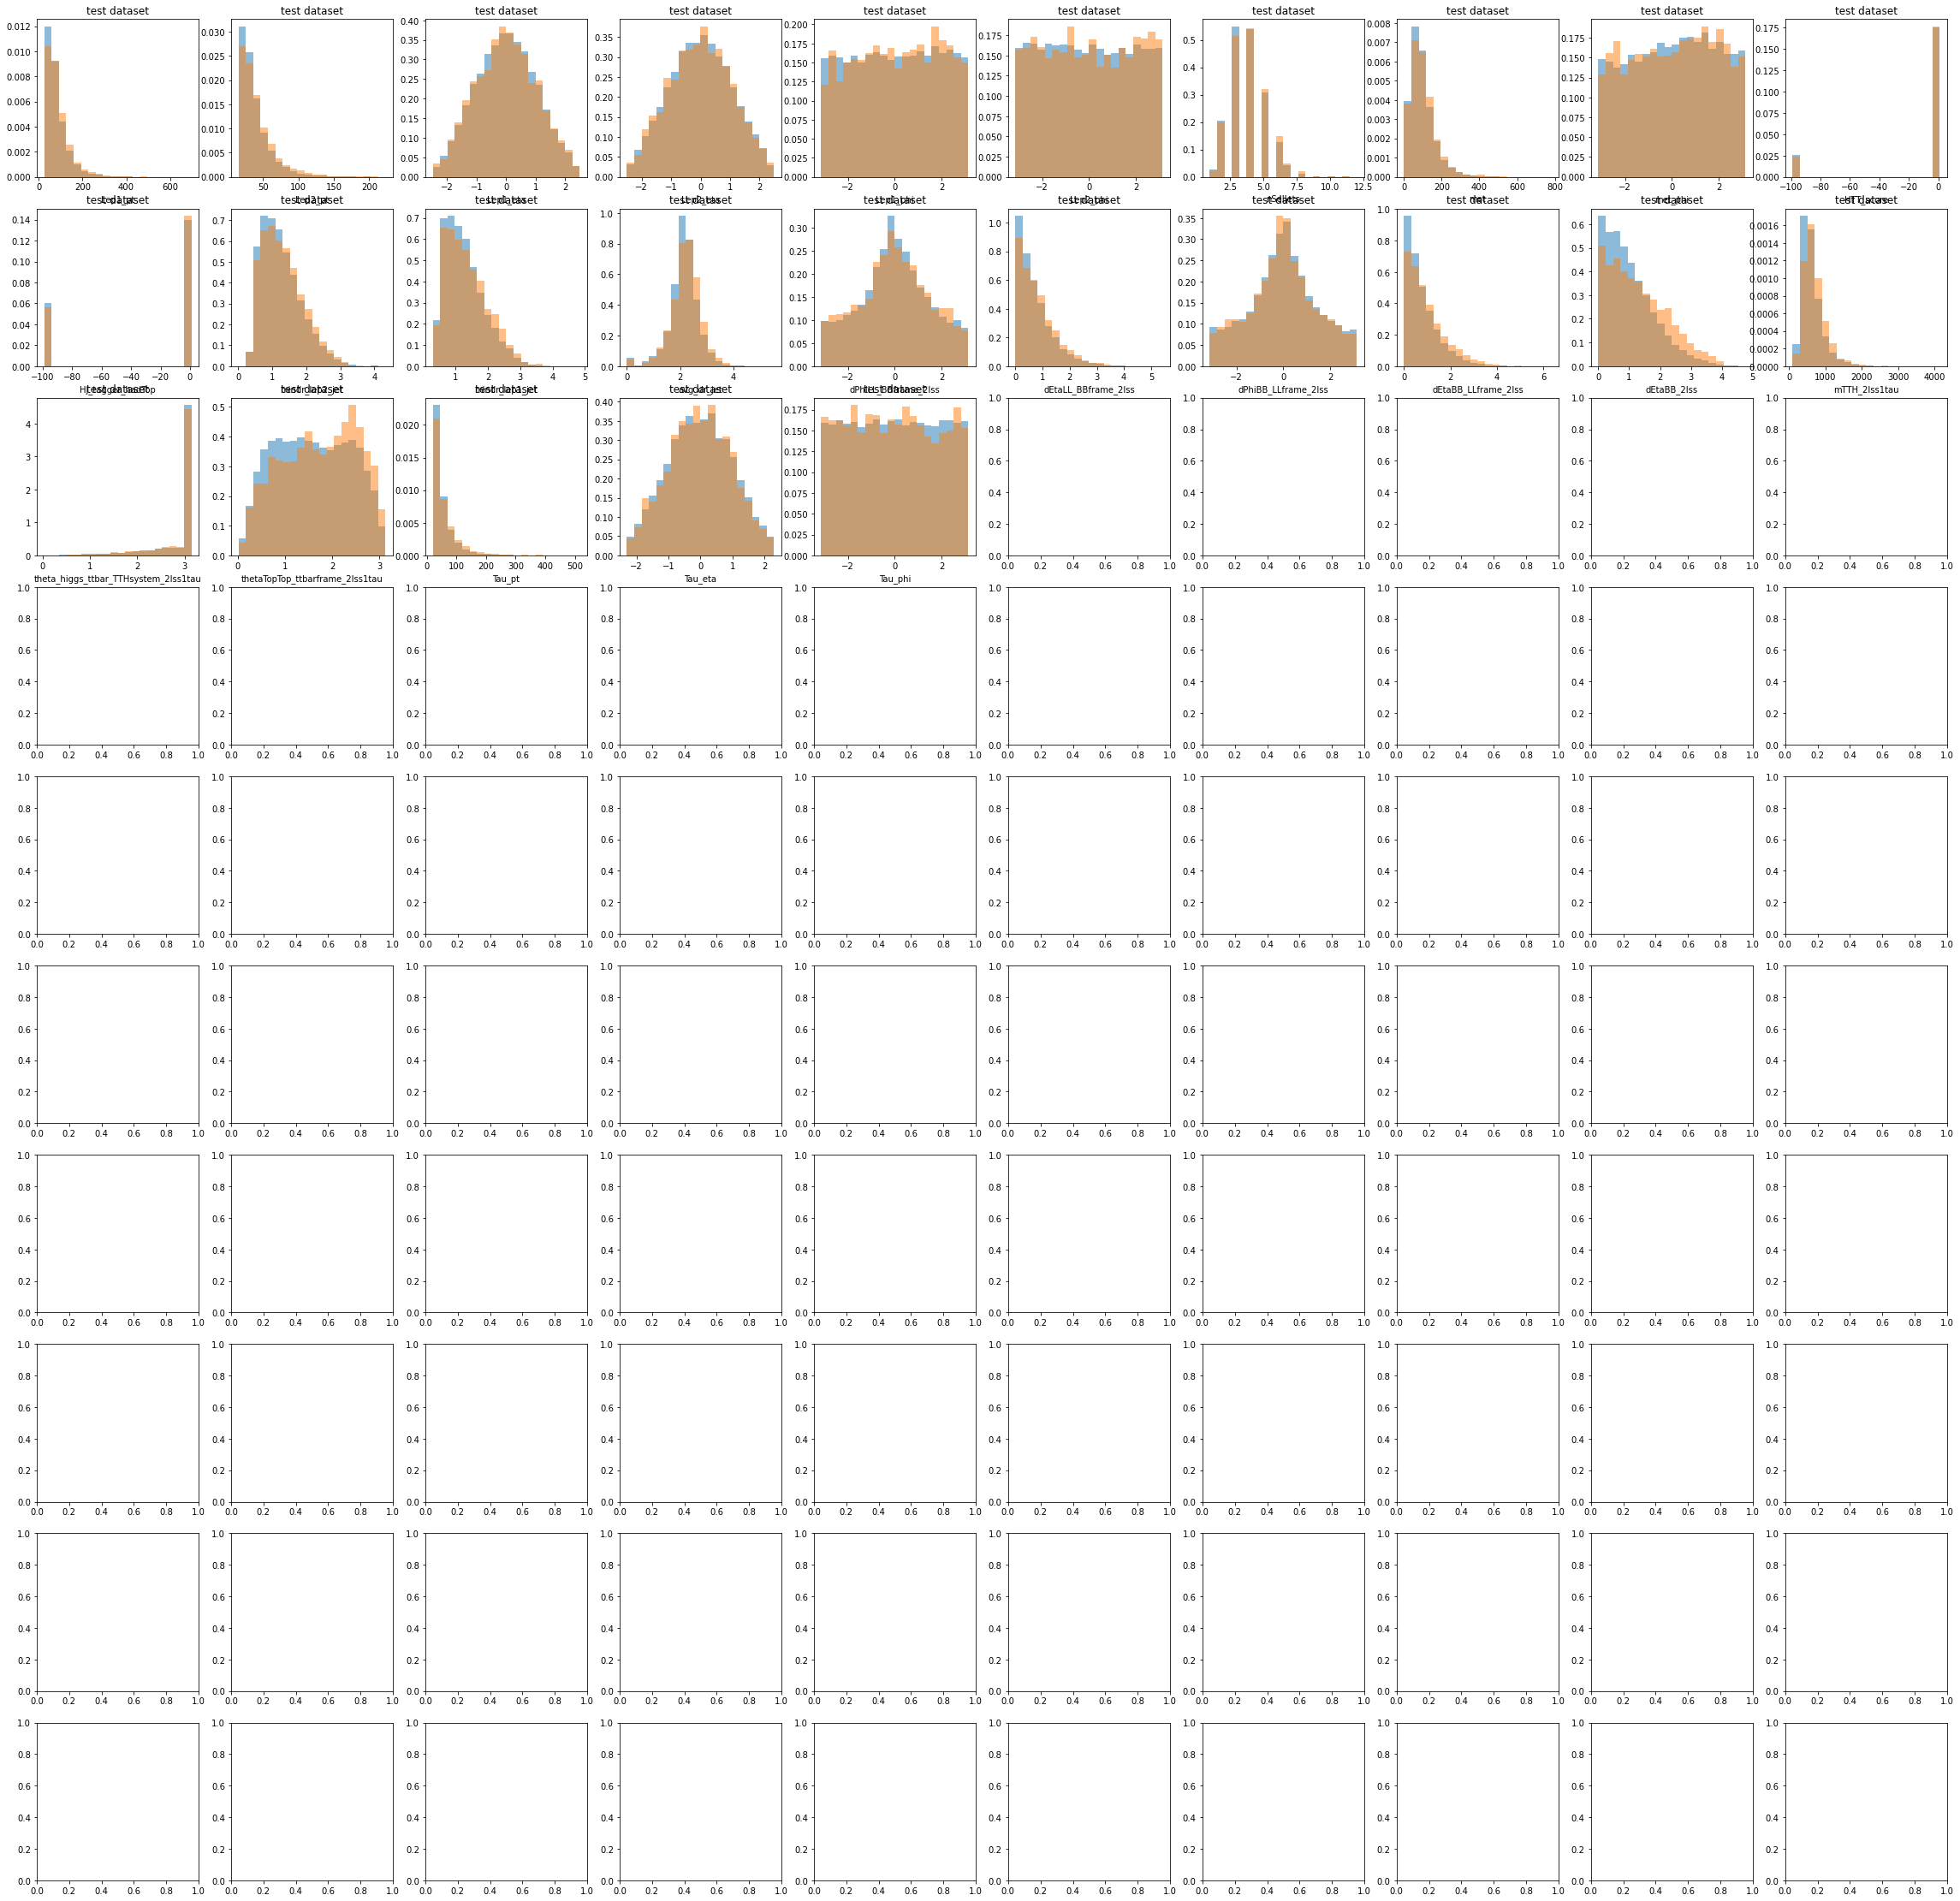

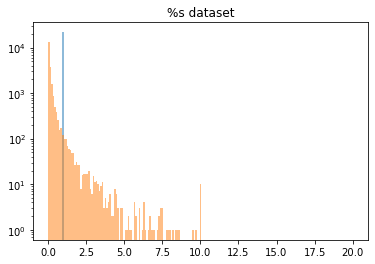

[20:31:41] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


FPR range: 0.0 1.0
TPR range: 0.0 1.0


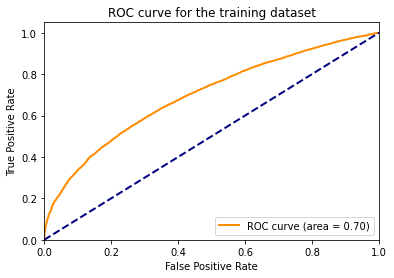

FPR range: 0.0 1.0
TPR range: 0.0 1.0


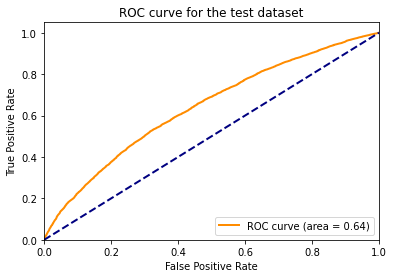

Accuracy (train): 82.91%
Accuracy (test): 82.27%


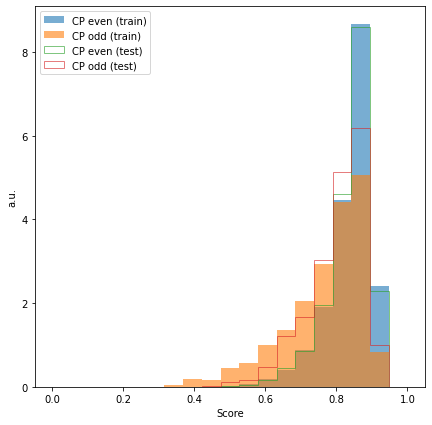

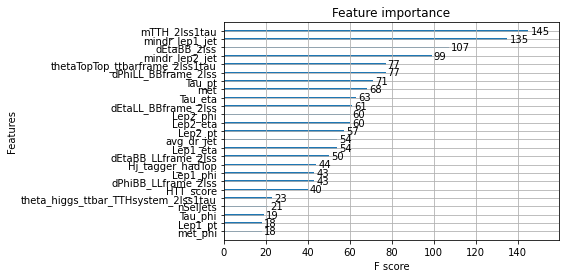

<Figure size 1152x864 with 0 Axes>

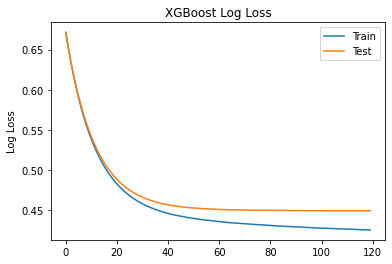

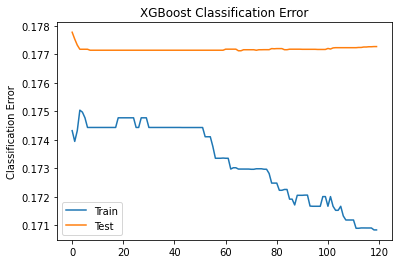

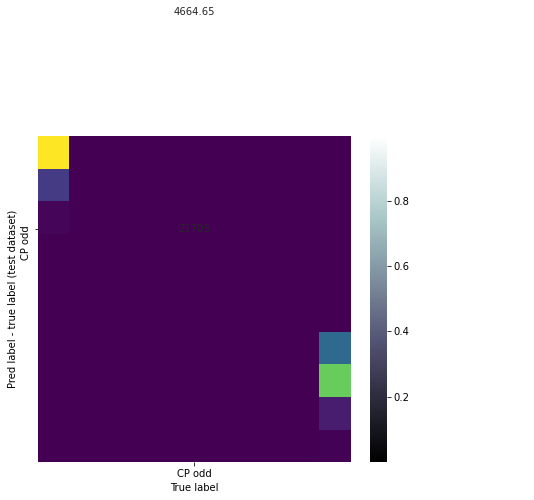

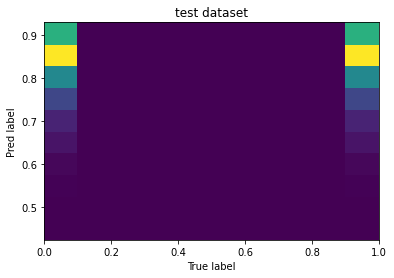

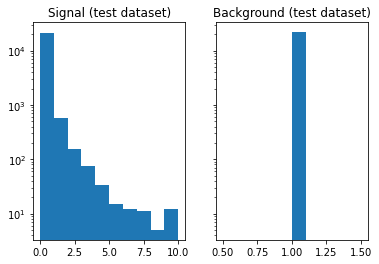

In [32]:


def plot_scores(true_train, score_train, true_test, score_test,wgt_train, wgt_test):
    plt.figure(figsize=(7,7))
    bins=np.linspace(0,1,20)
    plt.hist(score_train[true_train==0], histtype="bar", label='CP even (train)', weights=wgt_train[true_train==0], alpha=0.6 ,density=True, bins=bins)
    plt.hist(score_train[true_train==1], histtype="bar", label='CP odd (train)',  weights=wgt_train[true_train==1], alpha=0.6  ,density=True, bins=bins)
    plt.hist(score_test[true_test==0], histtype="step", label='CP even (test)',  weights=wgt_test[true_test==0], alpha=0.6 ,density=True, bins=bins)
    plt.hist(score_test[true_test==1], histtype="step", label='CP odd (test)',   weights=wgt_test[true_test==1], alpha=0.6  ,density=True, bins=bins)
    plt.xlabel('Score')
    plt.ylabel('a.u.')
    plt.legend(loc='best')
    plt.show()

    
# Retrain best model to make plots
# Copied by hand from best_model_set, must find a way of doing it automatically
params={'learning_rate' : 0.05,
          'n_estimators' : 120,
          'max_depth' : 4,
          'subsample' : 0.8,
          'colsample_bytree' : 1,
          'gamma' : 5
         }
thefeatures=['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'nSelJets', 'met', 'met_phi', 'HTT_score', 'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'theta_higgs_ttbar_TTHsystem_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta', 'Tau_phi']
tsm= train_single_model(params, data_tth, thefeatures, oddevensplit=True, fillna=False, debug=True)
